![Architecture](figures/image2_ysmali.png)

\begin{gather*}
h_t​ = \tanh(x_t ​W_{ih}^T​+b_{ih}​+h_{t−1​}W_{hh}^T​+b_{hh}​)
\end{gather*}

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import os
import sys
import math
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
import mlflow
from mlflow.models import infer_signature
from mlflow.data.sources import LocalArtifactDatasetSource

import seaborn as sns
from tqdm.notebook import tqdm, trange

sys.path.append('../')
from src.preprocess import prepare_time_series_data, split_data
from src.train import run_training, EarlyStopper

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LOOKBACK = 5
HORIZON = 1
NUM_FACTORS = 1

BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.01
LR_DECAY = 0.8
LR_PATIENCE = 3
PATIENCE = 5
MIN_DELTA = 1e-5

HIDDEN_SIZE = 32
NUM_LAYERS = 2
DROPOUT = 0

In [4]:
sns.set_theme('paper', rc={'figure.figsize': (16, 4)})

torch.manual_seed(42)

training_params = {
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'lr_decay': LR_DECAY,
    'lr_patience':LR_PATIENCE,
    'patience': PATIENCE,
    'min_delta': MIN_DELTA
}

data_params = {
    'lookback': 5,
    'horizon': 1,
    'num_factors': 1,
}

model_params = {
    'hidden_size': 32,
    'num_layers': 2,
    'dropout': 0.2
}

mlflow.set_experiment("Stock Market Predictions")
mlflow.start_run(run_name="ResNLS")
mlflow.log_params({**training_params, **data_params, **model_params})

In [5]:
DATA_FILE = '../data/SSEC.csv'
df = pd.read_csv(DATA_FILE, index_col='Date')
data = df['Close'].values

mlflow.log_input(mlflow.data.from_pandas(df[['Close']], LocalArtifactDatasetSource(DATA_FILE), name=os.path.basename(DATA_FILE)))

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = int(0.7*len(data))
val_size = int(0.15*len(data))
test_size = len(data) - train_size - val_size

mlflow.log_param('train_size', train_size)
mlflow.log_param('val_size', val_size)
mlflow.log_param('test_size', test_size)

data_train, data_val, data_test = split_data(data, train_size, val_size, test_size)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_time_series_data(
    data_train, data_val, data_test, scaler=scaler, device=DEVICE, **data_params
)

\begin{gather*}
L = \textrm{sequence length} = \textrm{lookback} \\
H_{in} = \textrm{input\_size} = \textrm{num\_factors} \\
H_{out} = \textrm{output\_size} = \textrm{horizon} \\
X \sim (N,L,H_{in}),\ y \sim (N,H_{out})
\end{gather*}

In [7]:
X_train.size(), y_train.size(), X_val.size(), y_val.size(), X_test.size(), y_test.size()

(torch.Size([2377, 5, 1]),
 torch.Size([2377, 1]),
 torch.Size([505, 5, 1]),
 torch.Size([505, 1]),
 torch.Size([506, 5, 1]),
 torch.Size([506, 1]))

In [8]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, output_size=1,*, hidden_size=1, num_layers=1, dropout=0):
        super(RNNModel, self).__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
model = RNNModel(input_size = data_params['num_factors'], output_size = data_params['horizon'], **model_params).to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

mlflow.log_param('criterion', type(criterion).__name__)
mlflow.log_param('optimizer', type(optimizer).__name__)

'Adam'

In [11]:
metric = nn.L1Loss().to(DEVICE)
mlflow.log_param('metric', type(metric).__name__)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=LR_PATIENCE)
mlflow.log_param('scheduler', type(scheduler).__name__)

early_stopper = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)

In [12]:
train_losses, val_losses = run_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    metric,
    scheduler,
    early_stopper
)

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

Early stopping at epoch 13


<Axes: title={'center': 'Losses'}>

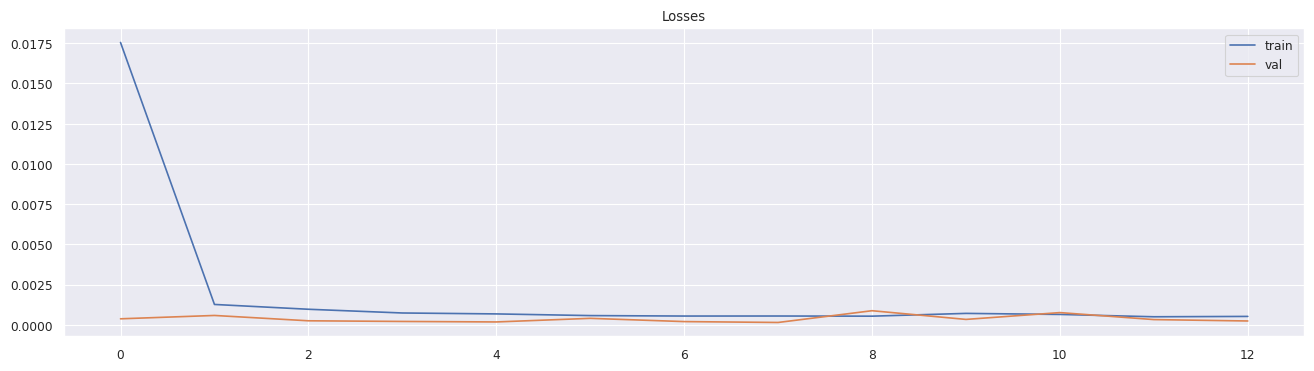

In [13]:
pd.DataFrame(data={'train': train_losses[::len(train_losses)//len(val_losses)], 'val': val_losses}).plot(title='Losses')

Registered model 'RNN' already exists. Creating a new version of this model...
2025/03/10 19:40:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RNN, version 20
Created version '20' of model 'RNN'.


<Axes: xlabel='Date'>

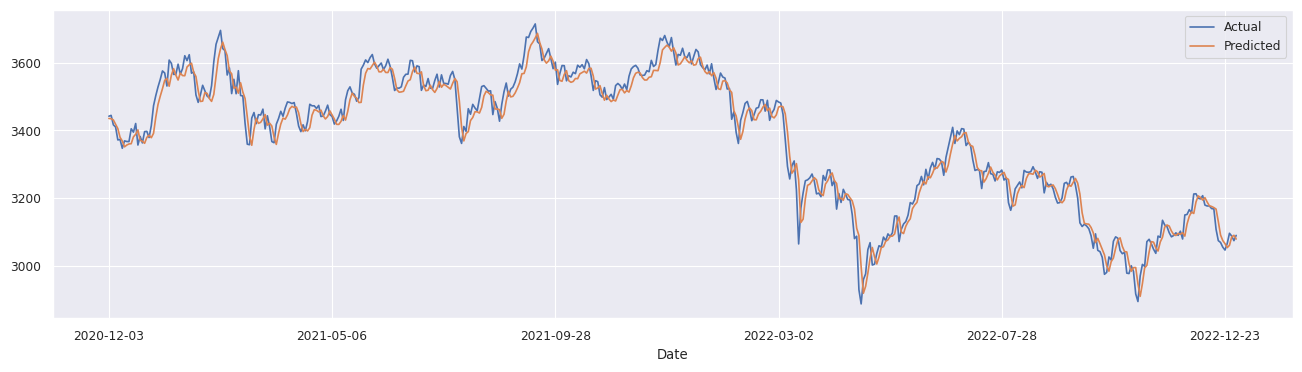

In [14]:
if os.path.exists(f'../models/{type(model).__name__}.pt'):    
    model.load_state_dict(torch.load(f"../models/{type(model).__name__}.pt"))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

y_pred_inv = scaler.inverse_transform(y_pred.cpu().detach().numpy())[:,0]
y_test_inv = scaler.inverse_transform(y_test.cpu().detach().numpy())[::HORIZON,0]

mlflow.pytorch.log_model(
    registered_model_name="RNN",
    artifact_path="RNN",
    pytorch_model=model,
    input_example=X_test.cpu().detach().numpy(),
    signature=infer_signature(X_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
)

pd.DataFrame([y_test_inv, y_pred_inv], index=['Actual', 'Predicted'], columns=df.index[-len(X_test):]).T.plot()

In [15]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(y_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_pred_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric('test_mae', mae)
mlflow.log_metric('test_mse', mse)
mlflow.log_metric('test_rmse', rmse)

print(f"Test MAE: {mae:.4f}  Test MSE: {mse:.4f} Test RMSE: {rmse:.4f}")

Test MAE: 28.4570  Test MSE: 1342.8745 Test RMSE: 36.6453


<Axes: xlabel='Date'>

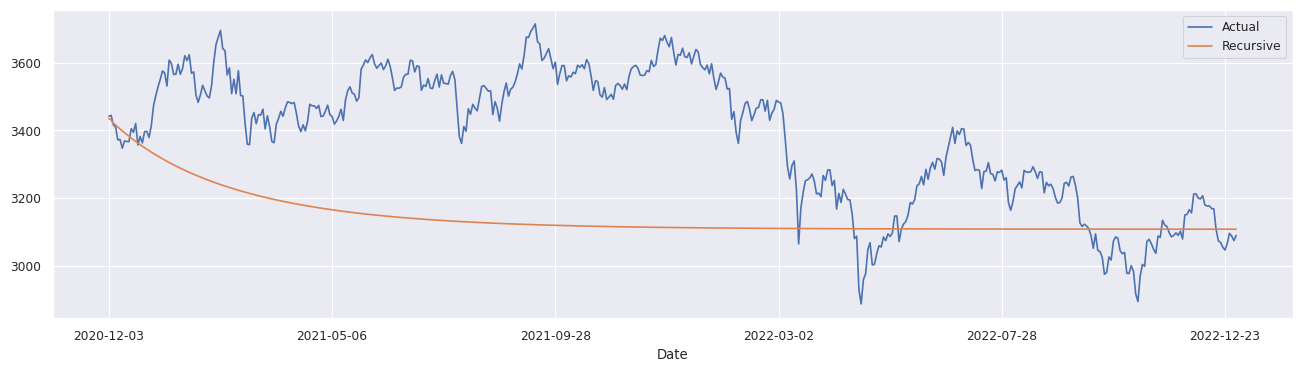

In [16]:
assert NUM_FACTORS == 1, "Recursive prediction only works with a single factor"
model.eval()
y_recursive = []

# Start with the first element of X_test
current_input = X_test[0].unsqueeze(0)

with torch.no_grad():
    for _ in range(len(X_test)):
        output = model(current_input).unsqueeze(-1)
        y_recursive.append(output[:,[0],:].cpu().numpy())

        # Prepare the next input by appending the prediction to the current input and removing the oldest value
        current_input = torch.cat((current_input[:, 1:, :], output[:,[0],:]), dim=1)

y_recursive = np.concatenate(y_recursive, axis=1).squeeze()
y_recursive_inv = scaler.inverse_transform(y_recursive.reshape(-1, 1)).flatten()

pd.DataFrame([y_test_inv, y_recursive_inv], index=['Actual', 'Recursive'], columns=df.index[-len(X_test):]).T.plot()

In [17]:
assert NUM_FACTORS == 1, "Recursive prediction only works with a single factor"
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_recursive_inv, y_test_inv)
mse = metrics.mean_squared_error(y_recursive_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_recursive_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric('test_mae_recursive', mae)
mlflow.log_metric('test_mse_recursive', mse)
mlflow.log_metric('test_rmse_recursive', rmse)
mlflow.end_run()

print(f"Recursive MAE: {mae:.4f} Recursive MSE: {mse:.4f} Recursive RMSE: {rmse:.4f}")

🏃 View run ResNLS at: http://172.18.0.2:5000/#/experiments/689077898730888678/runs/7f0d8ae40039449c8b12a86a002db075
🧪 View experiment at: http://172.18.0.2:5000/#/experiments/689077898730888678
Recursive MAE: 256.8716 Recursive MSE: 92521.9219 Recursive RMSE: 304.1742


<Axes: xlabel='Date'>

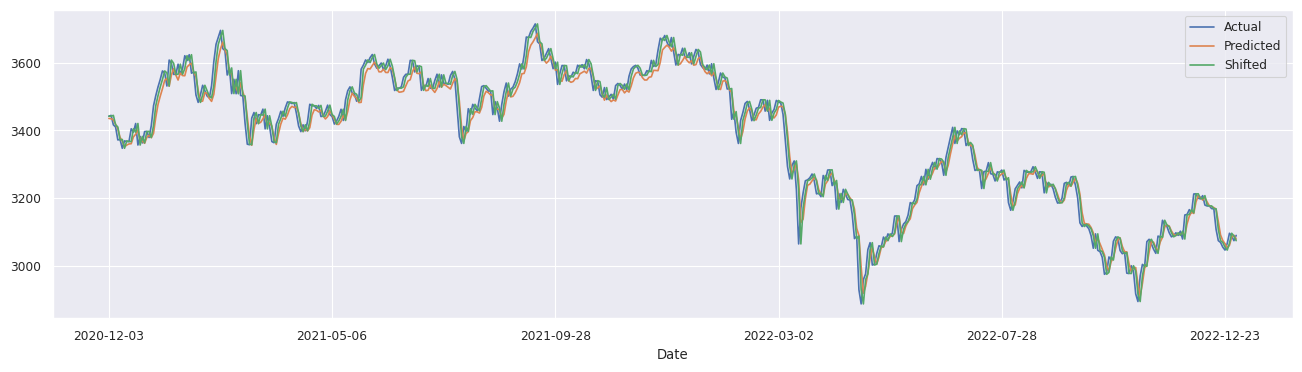

In [18]:
#Compare to the naive forecast
shifted_y_test_inv = np.roll(y_test_inv, 1).flatten()
shifted_y_test_inv[0] = y_test_inv[0]

pd.DataFrame([y_test_inv, y_pred_inv, shifted_y_test_inv], index=['Actual', 'Predicted', 'Shifted'], columns=df.index[-len(X_test):]).T.plot()

In [19]:
# Naive predictions
mae = metrics.mean_absolute_error(shifted_y_test_inv, y_test_inv)
mse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv)
rmse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv) ** 0.5

print(f"Naive MAE: {mae:.4f}  Naive MSE: {mse:.4f} Naive RMSE: {rmse:.4f}")

Naive MAE: 24.9891  Naive MSE: 1112.6173 Naive RMSE: 33.3559


<Axes: xlabel='Date'>

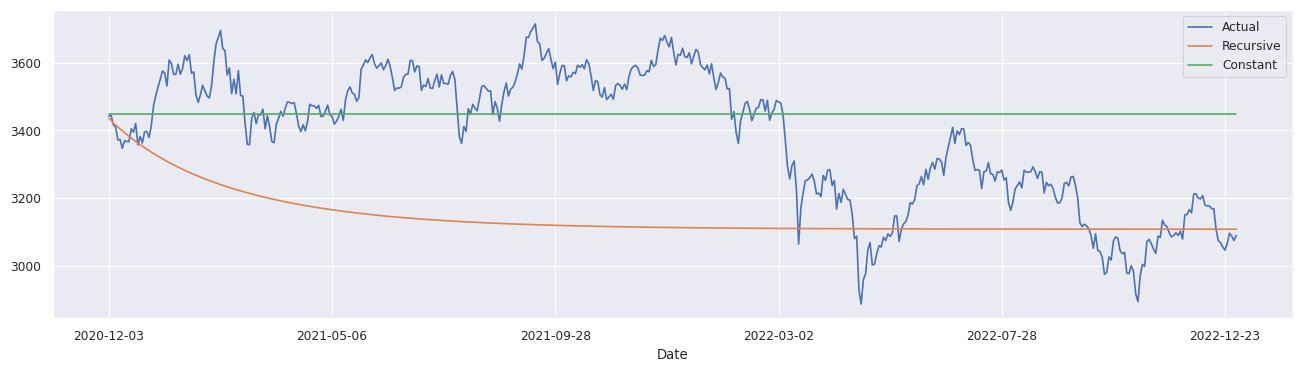

In [20]:
const_pred_inv = np.full_like(y_test_inv.flatten(), scaler.inverse_transform(X_test[0].cpu().numpy().flatten().reshape(-1, 1))[-1][0])

pd.DataFrame([y_test_inv, y_recursive_inv, const_pred_inv], index=['Actual', 'Recursive', 'Constant'], columns=df.index[-len(X_test):]).T.plot()

In [21]:
# Constant prediction
mae = metrics.mean_absolute_error(const_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(const_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(const_pred_inv, y_test_inv) ** 0.5

print(f"Constant MAE: {mae:.4f} Constant MSE: {mse:.4f} Constant RMSE: {rmse:.4f}")

Constant MAE: 165.6979 Constant MSE: 42911.6953 Constant RMSE: 207.1514


<Axes: xlabel='Date'>

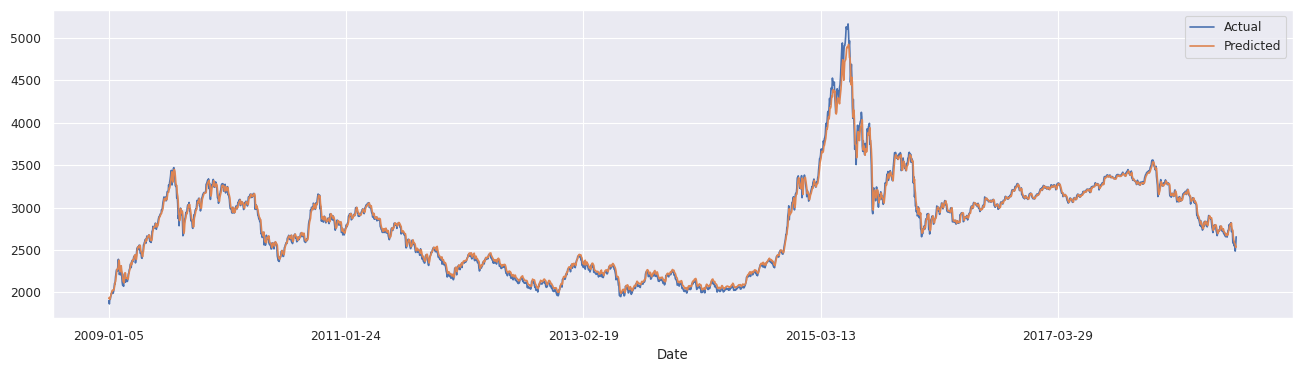

In [22]:
# Get predictions on the training dataset to check for overfitting
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())[:,0]
y_train_inv = scaler.inverse_transform(y_train.cpu().detach().numpy())[:,0]

pd.DataFrame([y_train_inv, y_train_pred_inv], index=['Actual', 'Predicted'], columns=df.index[:len(X_train)]).T.plot()

In [23]:
# Evaluate the model on the training dataset
mae = metrics.mean_absolute_error(y_train_pred_inv, y_train_inv)
mse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv)
rmse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv) ** 0.5

print(f"Train MAE: {mae:.4f} Train MSE: {mse:.4f} Train RMSE: {rmse:.4f}")

Train MAE: 35.9382 Train MSE: 2905.4109 Train RMSE: 53.9019
